In [1]:
import os
import numpy as np
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [2]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [4]:
# 计算粗糙度和光滑度矩阵

from scipy.io import loadmat
import os
import numpy as np

# 设置工作目录
download_folder_name = 'Tail_652_1'

# 设置结果存储目录
cluster_save_path = '../result/variable_cluster/rough&smooth'
if not os.path.exists(cluster_save_path):
    os.mkdir(cluster_save_path)

# 初始化pca结果存储array
roughness_matrix_list = []
smoothness_matrix_list = []

for mat_name in os.listdir(os.path.join(download_save_path, download_folder_name)):
    # 载入mat文件
    mat = loadmat(os.path.join(download_save_path, download_folder_name, mat_name))
    # 将mat文件整理成(163, )的array
    wshr_data = mat["WSHR"][0][0][0]
    sampling_data_array = []
    for var_list in var_groups_dict.values():
        for var_name in var_list:
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
            if var_rate == 1:
                sampling_data = var_data
            elif var_rate > 1: # 进行下采样
                sampling_data = random.sample(var_data.tolist(), k=len(wshr_data))
            else:
                sampling_data = random.choices(var_data, k=len(wshr_data))
            sampling_data_array.append(sampling_data)
    summary_data_array = np.squeeze(np.array(sampling_data_array))
    
    # 计算粗糙度
    roughness_matrix = summary_data_array[:, 1:] - summary_data_array[:, :-1]
    roughness_matrix_list.append(roughness_matrix)
    # 计算光滑程度
    smoothness_matrix = roughness_matrix[:, 1:] - roughness_matrix[:, :-1]
    smoothness_matrix_list.append(smoothness_matrix)

    # print(summary_data_array.shape)
    # print(roughness_matrix.shape)
    # print(smoothness_matrix.shape)

    # break

# 存储粗糙度和光滑度list
np.save(os.path.join(cluster_save_path, "roughness_matrix_list.npy"), roughness_matrix_list)
np.save(os.path.join(cluster_save_path, "smoothness_matrix_list.npy"), smoothness_matrix_list)

d:\coding\Anaconda\Software\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


ValueError: could not broadcast input array from shape (163,1971) into shape (163,)

d:\coding\Anaconda\Software\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\coding\Anaconda\Software\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster size 1: (399, 2)
Cluster size 2: (1, 2)
Cluster size 3: (2, 2)
Cluster size 4: (1, 2)
Cluster size 5: (1, 2)
Cluster size 6: (3, 2)
Cluster size 7: (1, 2)
Cluster size 8: (1, 2)
Cluster size 9: (1, 2)
Cluster size 10: (5, 2)
Cluster size 11: (1, 2)
Cluster size 12: (3, 2)
Cluster size 13: (133, 2)
Cluster size 14: (1, 2)
Cluster size 15: (11, 2)
Cluster size 16: (2, 2)
Cluster size 17: (89, 2)
Cluster size 18: (2, 2)
Cluster size 19: (1, 2)
Cluster size 20: (18, 2)
Cluster centers: [[-7.77567879e-02 -2.85474932e-03]
 [ 1.15379151e+02 -1.17966304e+02]
 [ 1.98555633e+02 -2.01161880e+02]
 [ 9.22939829e-01 -2.02387200e+02]
 [ 1.57047440e+02  1.02386256e-02]
 [ 6.61069226e+01  5.28857983e-02]
 [-5.19470344e+01  7.51776897e-03]
 [ 1.56240315e+02 -1.57935828e+02]
 [ 7.28844404e+01 -7.32565385e+01]
 [-2.33216204e+01  2.39858924e-03]
 [-1.01822919e+02  3.42414533e-03]
 [ 2.28661285e+01  8.61087981e-03]
 [ 2.22534360e+00 -1.16917113e-02]
 [ 3.07770435e-01 -3.96904602e+01]
 [-1.01321581e+

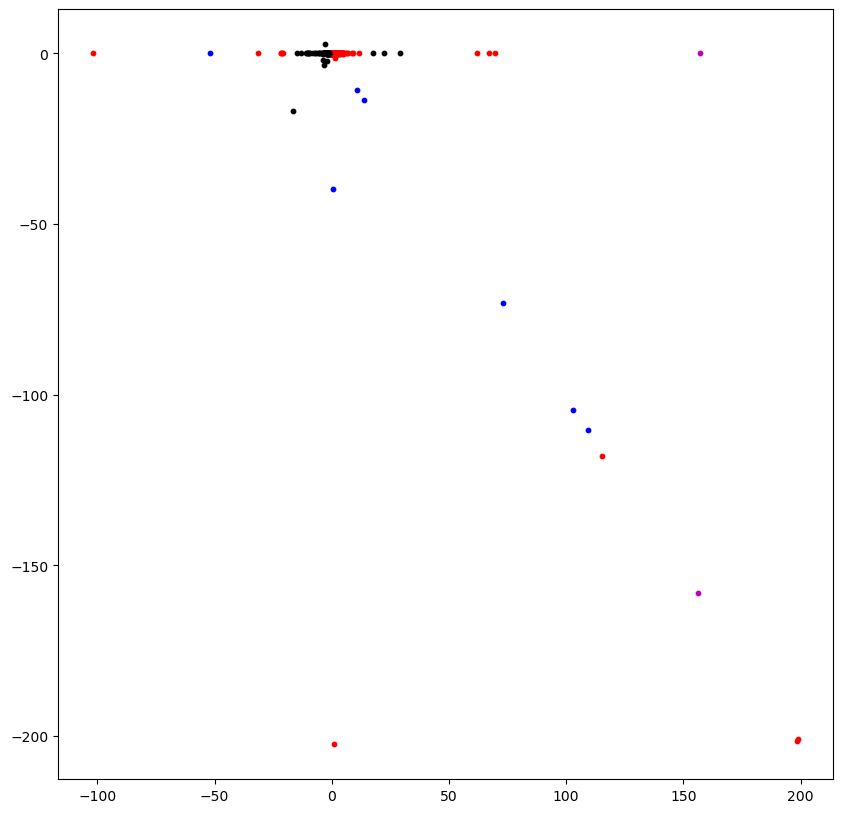

In [30]:
# 进行K-means聚类
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 初始化(粗糙度，光滑度)存储列表
metrics_list = []

# 将粗糙度和光滑度的均值tuple作为聚类metrics
for i in range(len(roughness_matrix_list)):
    metrics_list.append([np.mean(roughness_matrix_list[i]), np.mean(smoothness_matrix_list[i])])

metrics_array = np.array(metrics_list)
np.save(os.path.join(cluster_save_path, "metrics_array.npy"), metrics_array)

# 定义聚类方法
def kmeans_clustering(data, K, max_iter=100):
    # 初始化聚类中心
    centers = []
    centers.append(np.random.choice(data))
    # centers.append(17500)
    for _ in range(K-1):
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centers]) for x in data])
        prob = distances / distances.sum()
        cumulative_prob = prob.cumsum()
        r = np.random.rand()
        for j, p in enumerate(cumulative_prob):
            if r < p:
                centers.append(data[j])
                break

    iIter = 0
    for _ in range(max_iter):
        # 计算每个样本与聚类中心的距离
        distances = np.abs(data[:, np.newaxis] - centers)
        # 将样本分配到最近的簇中
        labels = np.argmin(distances, axis=1)
        # 更新聚类中心
        new_centers = np.array([np.mean(data[labels == k]) if np.sum(labels == k) != 0 else centers[k] for k in range(K)])
        # 判断聚类中心是否变化
        if np.allclose(centers, new_centers):
            print("Iteration times = ", iIter)
            break
        centers = new_centers
        iIter += 1
    return labels, centers

def kmeans_plus_plus_clustering(X, n_clusters):
    X = np.array(X).reshape(-1, 2)
    # print(X.shape)
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
    kmeans.fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers

# 聚类
K = 20
cluster_labels, cluster_centers = kmeans_plus_plus_clustering(metrics_array, K)
np.save(os.path.join(cluster_save_path, "cluster_labels.npy"), cluster_labels)

# # 打印聚类结果
# for k in range(K):
#     cluster_data = metrics_array[cluster_labels == k]
#     print(f"Cluster std {k+1}: {np.std(cluster_data)}")
for k in range(K):
    cluster_data = metrics_array[cluster_labels == k]
    print(f"Cluster size {k+1}: {cluster_data.shape}")

# 打印聚类中心
print("Cluster centers:", cluster_centers)

# 可视化
selected_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']
colors = [selected_colors[i%len(selected_colors)] for i in cluster_labels]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(metrics_array[:,0], metrics_array[:,1], cluster_labels)
plt.figure(figsize=(10, 10))
for i in range(K):
    plt.scatter(metrics_array[cluster_labels == i][:,0], metrics_array[cluster_labels == i][:,1], c=colors[i], s=10)
# plt.xlabel("Cluster id")
# plt.ylabel("DWPT length")
# plt.title("DWPT clusters")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plt.savefig(os.path.join(dwpt_list_savepath, "DWPT_clusters.png"), bbox_inches='tight')
plt.show()